# Transfer Learning with TensorFlow Part 1: Feature Extraction

We're going to go through the following with TensorFlow:

* Introduce transfer learning (a way to beat all of our old self-built models)
* Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
* Build a transfer learning feature extraction model using TensorFlow Hub
* Introduce the TensorBoard callback to track model training results
* Compare model results using TensorBoard

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from helper import plot_loss_curves, create_model
import os
import cv2
import pathlib
import random
import zipfile
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam


## Import and Inspect the data

In [2]:
# # Get data (10% of labels)
# import zipfile

# # Download data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

In [3]:
# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("data/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/ramen'.
There are 0 directo

In [4]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Set the train and test directory paths
train_dir = "data/10_food_classes_10_percent/train"
test_dir = "data/10_food_classes_10_percent/test"

# Create train and test data generators and rescale the data
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.


Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* [Experiment tracking with TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [Model checkpointing](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [5]:
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

Because you're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:

* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's datetime.datetime().now()

## Creating models using TensorFlow Hub

Will be using the following two models from [TensorFlow Hub](https://tfhub.dev/):
1. [ResNetV2](https://arxiv.org/abs/1603.05027) - a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

In [6]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# New: EfficientNetB0 feature vector (version 2)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

### 1. Resnet50

In [7]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [8]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [9]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2") # name of log files
                                             ]
                                  )

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230810-193831
Epoch 1/5
24/24 [==============================] - 67s 3s/step - loss: 2.0351 - accuracy: 0.3080 - val_loss: 1.2619 - val_accuracy: 0.5972
Epoch 2/5
24/24 [==============================] - 63s 3s/step - loss: 0.9661 - accuracy: 0.7120 - val_loss: 0.8405 - val_accuracy: 0.7468
Epoch 3/5
24/24 [==============================] - 59s 3s/step - loss: 0.6516 - accuracy: 0.8013 - val_loss: 0.7384 - val_accuracy: 0.7664
Epoch 4/5
24/24 [==============================] - 60s 3s/step - loss: 0.5038 - accuracy: 0.8560 - val_loss: 0.7007 - val_accuracy: 0.7796
Epoch 5/5
24/24 [==============================] - 57s 2s/step - loss: 0.3939 - accuracy: 0.9053 - val_loss: 0.6557 - val_accuracy: 0.7952


It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...**with only 10 percent of the training images!** This is a testament to the power of transfer learning, and the power of the ResNetV250 architecture.

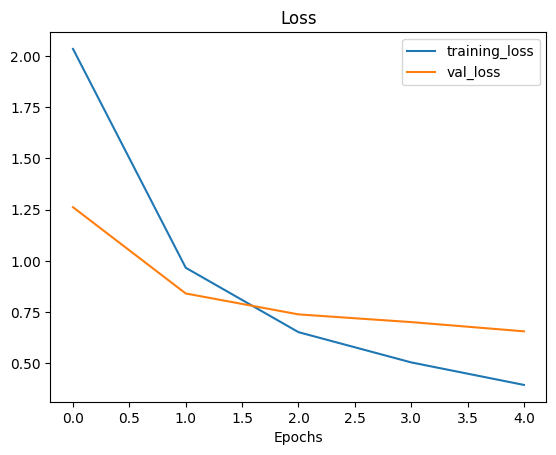

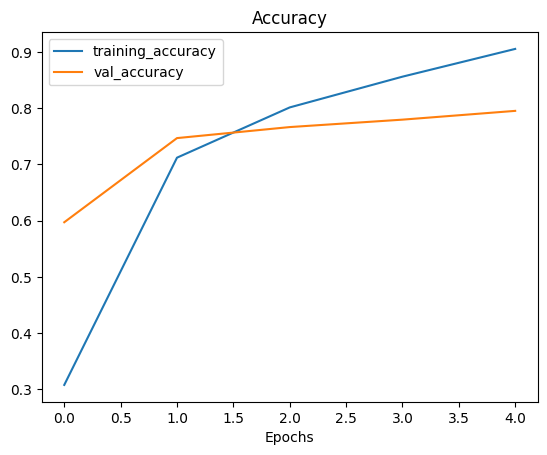

In [10]:
plot_loss_curves(resnet_history)

### 2. EfficientNetB0

In [11]:
# Create model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

# Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=Adam(),
                           metrics=["accuracy"])

# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0_10_percent_feature_extract")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0_10_percent_feature_extract/20230810-194342
Epoch 1/5
24/24 [==============================] - 33s 1s/step - loss: 2.0203 - accuracy: 0.3293 - val_loss: 1.5491 - val_accuracy: 0.5876
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.3286 - accuracy: 0.6707 - val_loss: 1.1453 - val_accuracy: 0.7016
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 1.0183 - accuracy: 0.7613 - val_loss: 0.9641 - val_accuracy: 0.7360
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.8483 - accuracy: 0.7973 - val_loss: 0.8672 - val_accuracy: 0.7592
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.7409 - accuracy: 0.8320 - val_loss: 0.8078 - val_accuracy: 0.7664


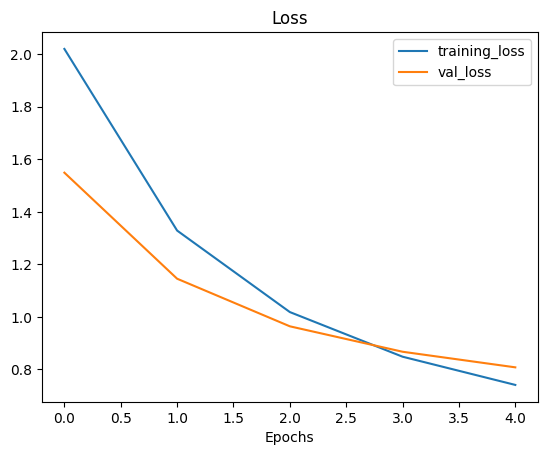

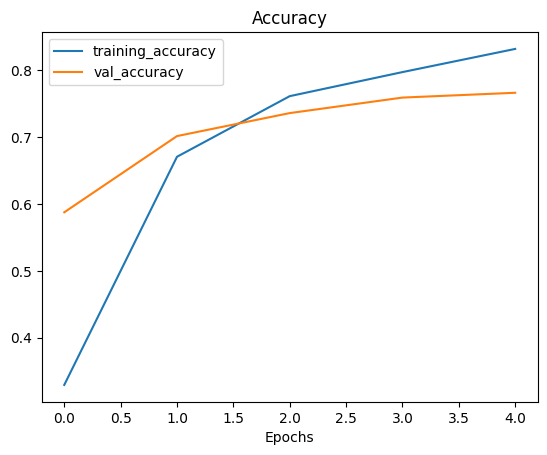

In [12]:
plot_loss_curves(efficientnet_history)

In [13]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


### MobileNetV2

In [15]:
MOBILENET_V2_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# Create Model
mobilenetv2_model = create_model(MOBILENET_V2_URL, num_classes=train_data_10_percent.num_classes)

# Compile model
mobilenetv2_model.compile(loss="categorical_crossentropy",
                          optimizer=Adam(),
                          metrics=["accuracy"])

# Fit model
mobilenetv2_history = mobilenetv2_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                   experiment_name="mobilenetv2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20230810-200759
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.8885 - accuracy: 0.3933 - val_loss: 1.2617 - val_accuracy: 0.6064
Epoch 2/5
24/24 [==============================] - 28s 1s/step - loss: 1.0078 - accuracy: 0.7053 - val_loss: 0.8556 - val_accuracy: 0.7408
Epoch 3/5
24/24 [==============================] - 28s 1s/step - loss: 0.7165 - accuracy: 0.8027 - val_loss: 0.7308 - val_accuracy: 0.7776
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.5666 - accuracy: 0.8520 - val_loss: 0.6608 - val_accuracy: 0.8000
Epoch 5/5
24/24 [==============================] - 39s 2s/step - loss: 0.4685 - accuracy: 0.8840 - val_loss: 0.6322 - val_accuracy: 0.8032


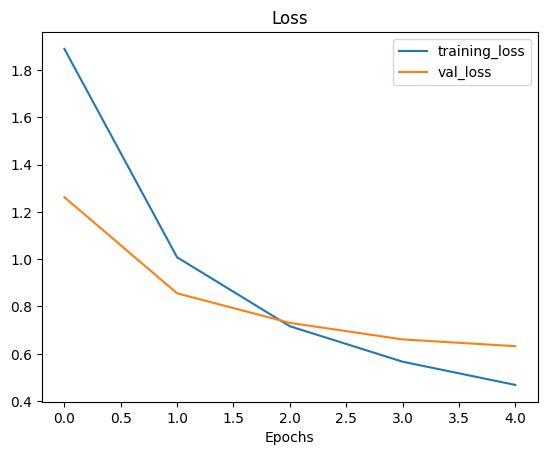

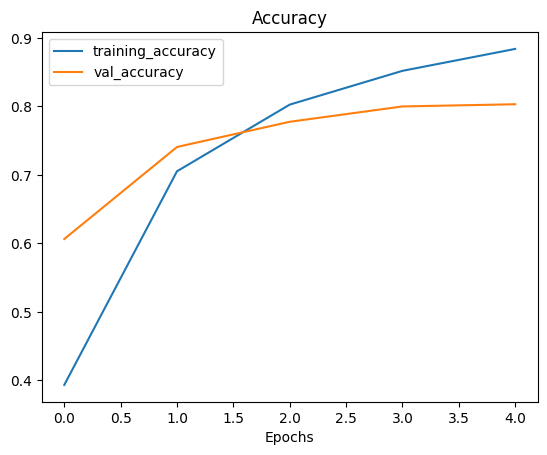

In [16]:
plot_loss_curves(mobilenetv2_history)

In [17]:
mobilenetv2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              2257984   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### Comparing models using TensorBoard

> 🔑 Note: These experiments are public, do not upload sensitive data. You can delete experiments if needed.

In [14]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

Traceback (most recent call last):
  File "/Users/oabas/miniconda3/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/Users/oabas/miniconda3/lib/python3.9/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/Users/oabas/miniconda3/lib/python3.9/site-packages/tensorboard/default.py", line 32, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/Users/oabas/miniconda3/lib/python3.9/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 25, in <module>
    from tensorboard.data import provider
  File "/Users/oabas/miniconda3/lib/python3.9/site-packages/tensorboard/data/__init__.py", line 17, in <module>
    from tensorboard.data import experimental  # noqa: F401
  File "/Users/oabas/miniconda3/lib/python3.9/site-packages/tensorboard/data/experimental/__init__.py", line 17, in <module>
    from tensorboard.data.experimental.experiment_from_dev import (  # noqa: F401
  File 

# Transfer Learning with TensorFlow Part 2: Fine-tuning

We're going to go through the follow with TensorFlow:

* Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
* Using the Keras Functional API (a differnt way to build models in Keras)
* Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
* Data augmentation (how to make your training dataset more diverse without adding more data)
* Running a series of modelling experiments on our Food Vision data
    * Model 0: a transfer learning model using the Keras Functional API
    * Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
    * Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
    * Model 3: a fine-tuned transfer learning model on 10% of the data
    * Model 4: a fine-tuned transfer learning model on 100% of the data
* Introduce the ModelCheckpoint callback to save intermediate training results
* Compare model experiments results using TensorBoard

In [18]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.13.0


In [19]:
# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("data/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/ramen'.
There are 0 directo

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Set the train and test directory paths
train_dir = "data/10_food_classes_10_percent/train/"
test_dir = "data/10_food_classes_10_percent/test/"

print("Training images:")
train_data_10_percent = preprocessing.image_dataset_from_directory(train_dir,
                                                                   target_size=IMAGE_SHAPE,
                                                                   batch_size=BATCH_SIZE,
                                                                   class_mode="categorical")

print("Testing images:")
test_data = preprocessing.image_dataset_from_directory(test_dir,
                                                       target_size=IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode="categorical")